In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, CuDNNLSTM, CuDNNGRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
from keras.utils.generic_utils import Progbar
from keras.layers.merge import _Merge
import keras.losses

from functools import partial

from collections import defaultdict

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
from sklearn import preprocessing
import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio
import scipy as scp
import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from sequence_logo_helper import plot_dna_logo

import pandas as pd

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

class EpochVariableCallback(Callback) :
    
    def __init__(self, my_variable, my_func) :
        self.my_variable = my_variable       
        self.my_func = my_func
        
    def on_epoch_begin(self, epoch, logs={}) :
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))


Using TensorFlow backend.


In [2]:

#optimus 5-prime functions 
def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].reshape(-1,1))
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df


def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors


def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2


#Train data
e_train = pd.read_csv("bottom5KIFuAUGTop5KIFuAUG.csv")
e_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'rl'].values.reshape(-1,1))

seq_e_train = one_hot_encode(e_train,seq_len=50)
x_train = seq_e_train
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1], x_train.shape[2]))
y_train = np.array(e_train['scaled_rl'].values)
y_train = np.reshape(y_train, (y_train.shape[0],1))

#Test data

e_test = pd.read_csv("randomSampleTestingAllAUGtypes.csv")
e_test.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_test.loc[:,'rl'].values.reshape(-1,1))

seq_e_test = one_hot_encode(e_test, seq_len=50)
x_test = seq_e_test
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1], x_test.shape[2]))
y_test = np.array(e_test['scaled_rl'].values)
y_test = np.reshape(y_test, (y_test.shape[0],1))


e_extra = pd.DataFrame({
    'utr' : [
        "CCGGCTTATCAATGGGAAGCGTCGATTGCGACAAGGGTCGTGCTCGCTAG",
        "CCGGCTTATCAATGGGAAGCGTCGATTGCGACAAGGGTCGTTAGCGCTAG",
        "CCGGCTTATCAATGGGAATGGTCGATTGCGACAAGGGTCGTTAGCGCTAG"
    ]
})
seq_e_extra = one_hot_encode(e_extra, seq_len=50)
x_extra = seq_e_extra
x_extra = np.reshape(x_extra, (x_extra.shape[0], 1, x_extra.shape[1], x_extra.shape[2]))

y_extra = np.zeros((x_extra.shape[0],1))

print("x_train.shape = " + str(x_train.shape))
print("x_test.shape = " + str(x_test.shape))
print("x_extra.shape = " + str(x_extra.shape))

print("y_train.shape = " + str(y_train.shape))
print("y_test.shape = " + str(y_test.shape))
print("y_extra.shape = " + str(y_extra.shape))


x_train.shape = (15008, 1, 50, 4)
x_test.shape = (3200, 1, 50, 4)
x_extra.shape = (3, 1, 50, 4)
y_train.shape = (15008, 1)
y_test.shape = (3200, 1)
y_extra.shape = (3, 1)


In [3]:
#Define sequence template

sequence_template = "N" * 50
sequence_mask = np.array([1 if sequence_template[j] == 'N' else 0 for j in range(len(sequence_template))])


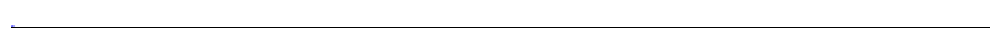

In [4]:
#Visualize background sequence distribution

pseudo_count = 1.0

x_mean = (np.sum(x_train, axis=(0, 1)) + pseudo_count) / (x_train.shape[0] + 4. * pseudo_count)
x_mean_logits = np.log(x_mean / (1. - x_mean))

plot_dna_logo(np.copy(x_mean), sequence_template=sequence_template, figsize=(14, 0.65), logo_height=1.0, plot_start=0, plot_end=205)


In [5]:
#Calculate mean training set conservation

entropy = np.sum(x_mean * -np.log(x_mean), axis=-1) / np.log(2.0)
conservation = 2.0 - entropy

x_mean_conservation = np.sum(conservation) / np.sum(sequence_mask)

print("Mean conservation (bits) = " + str(x_mean_conservation))


Mean conservation (bits) = 0.032049298346210106


In [6]:
#Calculate mean training set kl-divergence against background

x_train_clipped = np.clip(np.copy(x_train[:, 0, :, :]), 1e-8, 1. - 1e-8)

kl_divs = np.sum(x_train_clipped * np.log(x_train_clipped / np.tile(np.expand_dims(x_mean, axis=0), (x_train_clipped.shape[0], 1, 1))), axis=-1) / np.log(2.0)

x_mean_kl_divs = np.sum(kl_divs * sequence_mask, axis=-1) / np.sum(sequence_mask)
x_mean_kl_div = np.mean(x_mean_kl_divs)

print("Mean KL Div against background (bits) = " + str(x_mean_kl_div))


Mean KL Div against background (bits) = 1.9679329305814974


In [7]:
from tensorflow.python.framework import ops

#Stochastic Binarized Neuron helper functions (Tensorflow)
#ST Estimator code adopted from https://r2rt.com/beyond-binary-ternary-and-one-hot-neurons.html
#See Github https://github.com/spitis/

def st_sampled_softmax(logits):
    with ops.name_scope("STSampledSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.squeeze(tf.multinomial(logits, 1), 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

def st_hardmax_softmax(logits):
    with ops.name_scope("STHardmaxSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.argmax(nt_probs, 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

@ops.RegisterGradient("STMul")
def st_mul(op, grad):
    return [grad, grad]

#Gumbel Distribution Sampler
def gumbel_softmax(logits, temperature=0.5) :
    gumbel_dist = tf.contrib.distributions.RelaxedOneHotCategorical(temperature, logits=logits)
    batch_dim = logits.get_shape().as_list()[0]
    onehot_dim = logits.get_shape().as_list()[1]
    return gumbel_dist.sample()


In [8]:
#aparent_l_test, aparent_d_test#PWM Masking and Sampling helper functions

def mask_pwm(inputs) :
    pwm, onehot_template, onehot_mask = inputs

    return pwm * onehot_mask + onehot_template

def sample_pwm_st(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, 4))
    sampled_pwm = st_sampled_softmax(flat_pwm)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, 4))

def sample_pwm_gumbel(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, 4))
    sampled_pwm = gumbel_softmax(flat_pwm, temperature=0.5)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, 4))

#Generator helper functions
def initialize_sequence_templates(generator, sequence_templates, background_matrices) :

    embedding_templates = []
    embedding_masks = []
    embedding_backgrounds = []

    for k in range(len(sequence_templates)) :
        sequence_template = sequence_templates[k]
        onehot_template = iso.OneHotEncoder(seq_length=len(sequence_template))(sequence_template).reshape((1, len(sequence_template), 4))

        for j in range(len(sequence_template)) :
            if sequence_template[j] not in ['N', 'X'] :
                nt_ix = np.argmax(onehot_template[0, j, :])
                onehot_template[:, j, :] = -4.0
                onehot_template[:, j, nt_ix] = 10.0
            elif sequence_template[j] == 'X' :
                onehot_template[:, j, :] = -1.0

        onehot_mask = np.zeros((1, len(sequence_template), 4))
        for j in range(len(sequence_template)) :
            if sequence_template[j] == 'N' :
                onehot_mask[:, j, :] = 1.0

        embedding_templates.append(onehot_template.reshape(1, -1))
        embedding_masks.append(onehot_mask.reshape(1, -1))
        embedding_backgrounds.append(background_matrices[k].reshape(1, -1))

    embedding_templates = np.concatenate(embedding_templates, axis=0)
    embedding_masks = np.concatenate(embedding_masks, axis=0)
    embedding_backgrounds = np.concatenate(embedding_backgrounds, axis=0)

    generator.get_layer('template_dense').set_weights([embedding_templates])
    generator.get_layer('template_dense').trainable = False

    generator.get_layer('mask_dense').set_weights([embedding_masks])
    generator.get_layer('mask_dense').trainable = False
    
    generator.get_layer('background_dense').set_weights([embedding_backgrounds])
    generator.get_layer('background_dense').trainable = False

#Generator construction function
def build_sampler(batch_size, seq_length, n_classes=1, n_samples=1, sample_mode='st') :

    #Initialize Reshape layer
    reshape_layer = Reshape((1, seq_length, 4))
    
    #Initialize background matrix
    onehot_background_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='zeros', name='background_dense')

    #Initialize template and mask matrices
    onehot_template_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='zeros', name='template_dense')
    onehot_mask_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='ones', name='mask_dense')

    #Initialize Templating and Masking Lambda layer
    masking_layer = Lambda(mask_pwm, output_shape = (1, seq_length, 4), name='masking_layer')
    background_layer = Lambda(lambda x: x[0] + x[1], name='background_layer')
    
    #Initialize PWM normalization layer
    pwm_layer = Softmax(axis=-1, name='pwm')
    
    #Initialize sampling layers
    sample_func = None
    if sample_mode == 'st' :
        sample_func = sample_pwm_st
    elif sample_mode == 'gumbel' :
        sample_func = sample_pwm_gumbel
    
    upsampling_layer = Lambda(lambda x: K.tile(x, [n_samples, 1, 1, 1]), name='upsampling_layer')
    sampling_layer = Lambda(sample_func, name='pwm_sampler')
    permute_layer = Lambda(lambda x: K.permute_dimensions(K.reshape(x, (n_samples, batch_size, 1, seq_length, 4)), (1, 0, 2, 3, 4)), name='permute_layer')
    
    def _sampler_func(class_input, raw_logits) :
        
        #Get Template and Mask
        onehot_background = reshape_layer(onehot_background_dense(class_input))
        onehot_template = reshape_layer(onehot_template_dense(class_input))
        onehot_mask = reshape_layer(onehot_mask_dense(class_input))
        
        #Add Template and Multiply Mask
        pwm_logits = masking_layer([background_layer([raw_logits, onehot_background]), onehot_template, onehot_mask])
        
        #Compute PWM (Nucleotide-wise Softmax)
        pwm = pwm_layer(pwm_logits)
        
        #Tile each PWM to sample from and create sample axis
        pwm_logits_upsampled = upsampling_layer(pwm_logits)
        sampled_pwm = sampling_layer(pwm_logits_upsampled)
        sampled_pwm = permute_layer(sampled_pwm)

        sampled_mask = permute_layer(upsampling_layer(onehot_mask))
        
        return pwm_logits, pwm, sampled_pwm, onehot_mask, sampled_mask
    
    return _sampler_func


In [9]:
#Scrambler network definition

def make_resblock(n_channels=64, window_size=8, dilation_rate=1, group_ix=0, layer_ix=0, drop_rate=0.0) :

    #Initialize res block layers
    batch_norm_0 = BatchNormalization(name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_0')

    relu_0 = Lambda(lambda x: K.relu(x, alpha=0.0))

    conv_0 = Conv2D(n_channels, (1, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_0')

    batch_norm_1 = BatchNormalization(name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_1')

    relu_1 = Lambda(lambda x: K.relu(x, alpha=0.0))

    conv_1 = Conv2D(n_channels, (1, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_1')

    skip_1 = Lambda(lambda x: x[0] + x[1], name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_1')

    drop_1 = None
    if drop_rate > 0.0 :
        drop_1 = Dropout(drop_rate)
    
    #Execute res block
    def _resblock_func(input_tensor) :
        batch_norm_0_out = batch_norm_0(input_tensor)
        relu_0_out = relu_0(batch_norm_0_out)
        conv_0_out = conv_0(relu_0_out)

        batch_norm_1_out = batch_norm_1(conv_0_out)
        relu_1_out = relu_1(batch_norm_1_out)
        
        if drop_rate > 0.0 :
            conv_1_out = drop_1(conv_1(relu_1_out))
        else :
            conv_1_out = conv_1(relu_1_out)

        skip_1_out = skip_1([conv_1_out, input_tensor])
        
        return skip_1_out

    return _resblock_func

def mask_dropout_multi_scale(mask, drop_scales=[1, 2, 4, 7], min_drop_rate=0.0, max_drop_rate=0.5) :
    
    rates = K.random_uniform(shape=(K.shape(mask)[0], 1, 1, 1), minval=min_drop_rate, maxval=max_drop_rate)
    
    scale_logits = K.random_uniform(shape=(K.shape(mask)[0], len(drop_scales), 1, 1, 1), minval=-5., maxval=5.)
    scale_probs = K.softmax(scale_logits, axis=1)
    
    ret_mask = mask
    for drop_scale_ix, drop_scale in enumerate(drop_scales) :
        ret_mask = mask_dropout(ret_mask, rates * scale_probs[:, drop_scale_ix, ...], drop_scale=drop_scale)
    
    return K.switch(K.learning_phase(), ret_mask, mask)

def mask_dropout(mask, drop_rates, drop_scale=1) :
    
    random_tensor_downsampled = K.random_uniform(shape=(
        K.shape(mask)[0],
        1,
        K.cast(K.shape(mask)[2] / drop_scale, dtype=tf.int32),
        K.shape(mask)[3]
    ), minval=0.0, maxval=1.0)
    
    keep_mask_downsampled = random_tensor_downsampled >= drop_rates
    
    keep_mask = K.repeat_elements(keep_mask_downsampled, rep=drop_scale, axis=2)
    
    ret_mask = mask * K.cast(keep_mask, dtype=tf.float32)
    
    return ret_mask

def mask_dropout_single_scale(mask, drop_scale=1, min_drop_rate=0.0, max_drop_rate=0.5) :
    
    rates = K.random_uniform(shape=(K.shape(mask)[0], 1, 1, 1), minval=min_drop_rate, maxval=max_drop_rate)
    
    random_tensor_downsampled = K.random_uniform(shape=(
        K.shape(mask)[0],
        1,
        K.cast(K.shape(mask)[2] / drop_scale, dtype=tf.int32),
        K.shape(mask)[3]
    ), minval=0.0, maxval=1.0)
    
    keep_mask_downsampled = random_tensor_downsampled >= rates
    
    keep_mask = K.repeat_elements(keep_mask_downsampled, rep=drop_scale, axis=2)
    
    ret_mask = mask * K.cast(keep_mask, dtype=tf.float32)
    
    return K.switch(K.learning_phase(), ret_mask, mask)

def load_scrambler_network(seq_length=50, n_groups=1, n_resblocks_per_group=4, n_channels=32, window_size=8, dilation_rates=[1], drop_rate=0.0, drop_scales=[1, 5], min_drop_rate=0.0, max_drop_rate=0.5) :

    #Discriminator network definition
    conv_0 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_conv_0')
    
    mask_drop = Lambda(lambda x: mask_dropout_multi_scale(x, drop_scales=drop_scales, min_drop_rate=min_drop_rate, max_drop_rate=max_drop_rate), output_shape=(1, seq_length, 1), name='scrambler_mask_drop')
    #mask_drop = Lambda(lambda x: mask_dropout_single_scale(x, drop_scale=drop_scales[0], min_drop_rate=min_drop_rate, max_drop_rate=max_drop_rate), output_shape=(1, seq_length, 1), name='scrambler_mask_drop')
    mask_concat = Concatenate(axis=-1)
    mask_multiply = Lambda(lambda x: x[0] * x[1])
    
    skip_convs = []
    resblock_groups = []
    for group_ix in range(n_groups) :
        
        skip_convs.append(Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_skip_conv_' + str(group_ix)))
        
        resblocks = []
        for layer_ix in range(n_resblocks_per_group) :
            resblocks.append(make_resblock(n_channels=n_channels, window_size=window_size, dilation_rate=dilation_rates[group_ix], group_ix=group_ix, layer_ix=layer_ix, drop_rate=drop_rate))
        
        resblock_groups.append(resblocks)

    last_block_conv = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_last_block_conv')
    
    skip_add = Lambda(lambda x: x[0] + x[1], name='scrambler_skip_add')
    
    final_conv = Conv2D(1, (1, 1), strides=(1, 1), padding='same', activation='softplus', kernel_initializer='glorot_normal', name='scrambler_final_conv')
    
    onehot_to_logits = Lambda(lambda x: 2. * x - 1., name='scrambler_onehot_to_logits')
    
    scale_logits = Lambda(lambda x: x[1] * K.tile(x[0], (1, 1, 1, 4)), name='scrambler_logit_scale')
    
    def _scrambler_func(sequence_input, mask_input) :
        
        mask_dropped = mask_drop(mask_input)
        
        conv_0_out = conv_0(mask_concat([sequence_input, mask_dropped]))
        
        #Connect group of res blocks
        output_tensor = conv_0_out

        #Res block group execution
        skip_conv_outs = []
        for group_ix in range(n_groups) :
            skip_conv_out = skip_convs[group_ix](output_tensor)
            skip_conv_outs.append(skip_conv_out)

            for layer_ix in range(n_resblocks_per_group) :
                output_tensor = resblock_groups[group_ix][layer_ix](output_tensor)
        
        #Last res block extr conv
        last_block_conv_out = last_block_conv(output_tensor)

        skip_add_out = last_block_conv_out
        for group_ix in range(n_groups) :
            skip_add_out = skip_add([skip_add_out, skip_conv_outs[group_ix]])

        #Final conv out
        final_conv_out = mask_multiply([final_conv(skip_add_out), mask_dropped])
        
        #Scale logits by importance scores
        scaled_logits = scale_logits([final_conv_out, onehot_to_logits(sequence_input)])
        
        return scaled_logits, final_conv_out

    return _scrambler_func


In [10]:
#Keras loss functions

def get_margin_entropy_ame_masked(pwm_start, pwm_end, pwm_background, max_bits=1.0) :
    
    def _margin_entropy_ame_masked(pwm, pwm_mask) :
        conservation = pwm[:, 0, pwm_start:pwm_end, :] * K.log(K.clip(pwm[:, 0, pwm_start:pwm_end, :], K.epsilon(), 1. - K.epsilon()) / K.constant(pwm_background[pwm_start:pwm_end, :])) / K.log(2.0)
        conservation = K.sum(conservation, axis=-1)
        
        mask = K.max(pwm_mask[:, 0, pwm_start:pwm_end, :], axis=-1)
        n_unmasked = K.sum(mask, axis=-1)
        
        mean_conservation = K.sum(conservation * mask, axis=-1) / n_unmasked

        margin_conservation = K.switch(mean_conservation > K.constant(max_bits, shape=(1,)), mean_conservation - K.constant(max_bits, shape=(1,)), K.zeros_like(mean_conservation))
    
        return margin_conservation
    
    return _margin_entropy_ame_masked

def get_target_entropy_sme_masked(pwm_start, pwm_end, pwm_background, target_bits=1.0) :
    
    def _target_entropy_sme_masked(pwm, pwm_mask) :
        conservation = pwm[:, 0, pwm_start:pwm_end, :] * K.log(K.clip(pwm[:, 0, pwm_start:pwm_end, :], K.epsilon(), 1. - K.epsilon()) / K.constant(pwm_background[pwm_start:pwm_end, :])) / K.log(2.0)
        conservation = K.sum(conservation, axis=-1)
        
        mask = K.max(pwm_mask[:, 0, pwm_start:pwm_end, :], axis=-1)
        n_unmasked = K.sum(mask, axis=-1)
        
        mean_conservation = K.sum(conservation * mask, axis=-1) / n_unmasked

        return (mean_conservation - target_bits)**2
    
    return _target_entropy_sme_masked

def get_margin_lum_ame_masked(pwm_start, pwm_end) :
    
    def _margin_lum_ame(importance_scores, pwm_mask, max_lum) :
        p_ons = 2. * K.sigmoid(importance_scores[:, 0, pwm_start:pwm_end, 0]) - 1.
        
        mask = K.max(pwm_mask[:, 0, pwm_start:pwm_end, :], axis=-1)
        n_unmasked = K.sum(mask, axis=-1)
        
        mean_p_on = K.switch(n_unmasked > 0, K.sum(p_ons * mask, axis=-1) / n_unmasked, max_lum[:, 0])

        margin_p_on = K.switch(mean_p_on > max_lum[:, 0], mean_p_on - max_lum[:, 0], K.zeros_like(mean_p_on))
    
        return margin_p_on
    
    return _margin_lum_ame

def get_target_lum_sme_masked(pwm_start, pwm_end) :
    
    def _target_lum_sme(importance_scores, pwm_mask, target_lum) :
        p_ons = 2. * K.sigmoid(importance_scores[:, 0, pwm_start:pwm_end, 0]) - 1.
        
        mask = K.max(pwm_mask[:, 0, pwm_start:pwm_end, :], axis=-1)
        n_unmasked = K.sum(mask, axis=-1)
        
        mean_p_on = K.switch(n_unmasked > 0, K.sum(p_ons * mask, axis=-1) / n_unmasked, target_lum[:, 0])
        
        return (mean_p_on - target_lum[:, 0])**2
    
    return _target_lum_sme

def get_weighted_loss(loss_coeff=1.) :
    
    def _min_pred(y_true, y_pred) :
        return loss_coeff * y_pred
    
    return _min_pred

def get_mse(loss_coeff=1.) :
    #returns mse function for optimus 
    def _mse(y_true, y_pred):
        return K.mean((y_true - y_pred)**2, axis=-1)
    return _mse


In [11]:
K.clear_session()

In [12]:
#Initialize Encoder and Decoder networks
batch_size = 32
seq_length = 50
n_samples = 32
#sample_mode = 'st'
sample_mode = 'gumbel'

#Resnet parameters
resnet_n_groups = 5
resnet_n_resblocks_per_group = 4
resnet_n_channels = 32
resnet_window_size = 3
resnet_dilation_rates = [1, 2, 4, 2, 1]
resnet_drop_rate = 0.0

resnet_min_drop_rate = 0.0
resnet_max_drop_rate = 0.15
resnet_drop_scales = [1, 2, 5]

#Load scrambler
scrambler = load_scrambler_network(
    seq_length=seq_length,
    n_groups=resnet_n_groups,
    n_resblocks_per_group=resnet_n_resblocks_per_group,
    n_channels=resnet_n_channels, window_size=resnet_window_size,
    dilation_rates=resnet_dilation_rates,
    drop_rate=resnet_drop_rate,
    min_drop_rate=resnet_min_drop_rate,
    max_drop_rate=resnet_max_drop_rate,
    drop_scales=resnet_drop_scales
)

#Load sampler
sampler = build_sampler(batch_size, seq_length, n_classes=1, n_samples=n_samples, sample_mode=sample_mode)


In [13]:
#Load Predictor
predictor_path = 'optimusRetrainedMain.hdf5'

predictor = load_model(predictor_path)

predictor.trainable = False
predictor.compile(optimizer=keras.optimizers.SGD(lr=0.1), loss='mean_squared_error')


In [14]:
#Build scrambler model
scrambler_class = Input(shape=(1,), name='scrambler_class')
scrambler_input = Input(shape=(1, seq_length, 4), name='scrambler_input')
scrambler_drop = Input(shape=(1, seq_length, 1), name='scrambler_drop')

scrambler_logits, importance_scores = scrambler(scrambler_input, scrambler_drop)

pwm_logits, pwm, sampled_pwm, _, _ = sampler(scrambler_class, scrambler_logits)

scrambler_model = Model([scrambler_input, scrambler_drop, scrambler_class], [pwm_logits, pwm, sampled_pwm, importance_scores])

#Initialize Sequence Templates and Masks
initialize_sequence_templates(scrambler_model, [sequence_template], [x_mean_logits])

scrambler_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
    loss='mean_squared_error'
)



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [15]:
#Build Auto-scrambler pipeline

#Define model inputs
ae_scrambler_class = Input(shape=(1,), name='ae_scrambler_class')
ae_scrambler_input = Input(shape=(1, seq_length, 4), name='ae_scrambler_input')
ae_scrambler_drop = Input(shape=(1, seq_length, 1), name='ae_scrambler_drop')

#Run encoder and decoder
_, scrambled_pwm, scrambled_sample, pwm_mask, _ = sampler(ae_scrambler_class, scrambler(ae_scrambler_input, ae_scrambler_drop)[0])

#Define layer to deflate sample axis
deflate_scrambled_sample = Lambda(lambda x: K.reshape(x, (batch_size * n_samples, 1, seq_length, 4)), name='deflate_scrambled_sample')

#Deflate sample axis
scrambled_sample_deflated = deflate_scrambled_sample(scrambled_sample)


In [16]:

def _make_prediction(inputs, predictor=predictor) :
    pred_seq_in = inputs
     
    pred_seq_in_perm = tf.squeeze(pred_seq_in, 1)
    
    outputs = predictor(pred_seq_in_perm)
    
    return outputs

def _make_prediction_scrambled(inputs, predictor=predictor, n_samples=n_samples) :
    pred_seq_in = inputs
     
    pred_seq_in_perm = tf.squeeze(pred_seq_in, 1)
    
    outputs = predictor(pred_seq_in_perm)
    
    return outputs

#Make reference prediction on non-scrambled input sequence
y_pred_non_scrambled = Lambda(_make_prediction, name='make_prediction_non_scrambled')(ae_scrambler_input)

#Make prediction on scrambled sequence samples
y_pred_scrambled_deflated = Lambda(_make_prediction_scrambled, name='make_prediction_scrambled')(scrambled_sample_deflated)


In [17]:
#Define layer to inflate sample axis
inflate_scrambled_prediction = Lambda(lambda x: K.reshape(x, (batch_size, n_samples)), name='inflate_scrambled_prediction')

#Inflate sample axis
y_pred_scrambled = inflate_scrambled_prediction(y_pred_scrambled_deflated)

#Cost function parameters
pwm_start = 0
pwm_end = 50
target_bits = 0.125

#OPTIMUS: switched to MSE 
mse_loss_func = get_mse()

#Conservation cost
conservation_loss_func = get_target_entropy_sme_masked(pwm_start=pwm_start, pwm_end=pwm_end, pwm_background=x_mean, target_bits=1.8)

#Entropy cost
entropy_loss_func = get_target_entropy_sme_masked(pwm_start=pwm_start, pwm_end=pwm_end, pwm_background=x_mean, target_bits=target_bits)
#entropy_loss_func = get_margin_entropy_ame_masked(pwm_start=pwm_start, pwm_end=pwm_end, pwm_background=x_mean, max_bits=target_bits)

#Define annealing coefficient
anneal_coeff = K.variable(1.0)

#Execute NLL cost
mse_loss = Lambda(lambda x: mse_loss_func(K.tile(x[0], (1, K.shape(x[1])[1])), x[1]), name='mse')([y_pred_non_scrambled, y_pred_scrambled])

#Execute conservation cost
conservation_loss = Lambda(lambda x: anneal_coeff * conservation_loss_func(x[0], x[1]), name='conservation')([scrambled_pwm, pwm_mask])

#Execute entropy cost
entropy_loss = Lambda(lambda x: (1. - anneal_coeff) * entropy_loss_func(x[0], x[1]), name='entropy')([scrambled_pwm, pwm_mask])

loss_model = Model(
    [ae_scrambler_class, ae_scrambler_input, ae_scrambler_drop],
    [mse_loss, conservation_loss, entropy_loss]
)

#Initialize Sequence Templates and Masks
initialize_sequence_templates(loss_model, [sequence_template], [x_mean_logits])

opt = keras.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.9)
#opt = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)

loss_model.compile(
    optimizer=opt,
    loss={
        'mse' : get_weighted_loss(loss_coeff=1.0),
        'conservation' : get_weighted_loss(loss_coeff=1.0),
        'entropy' : get_weighted_loss(loss_coeff=10.0)
    }
)



In [18]:
#Training configuration

#Define number of training epochs
n_epochs = 50

#Define experiment suffix (optional)
experiment_suffix = "_example_if_uorf_seqs_drop_multi_scale_weight_10"

#Define anneal function
def _anneal_func(val, epoch, n_epochs=n_epochs) :
    if epoch in [0] :
        return 1.0
    
    return 0.0

architecture_str = "resnet_" + str(resnet_n_groups) + "_" + str(resnet_n_resblocks_per_group) + "_" + str(resnet_n_channels) + "_" + str(resnet_window_size) + "_" + str(resnet_drop_rate).replace(".", "") + "_" + str(resnet_min_drop_rate).replace(".", "") + "_to_" + str(resnet_max_drop_rate).replace(".", "")

dataset_name = "egfp_unmod_1"

model_name = "autoscrambler_dataset_" + dataset_name + "_sample_mode_" + sample_mode + "_n_samples_" + str(n_samples) + "_" + architecture_str + "_n_epochs_" + str(n_epochs) + "_target_bits_" + str(target_bits).replace(".", "") + experiment_suffix

print("Model save name = " + model_name)


Model save name = autoscrambler_dataset_egfp_unmod_1_sample_mode_gumbel_n_samples_32_resnet_5_4_32_3_00_00_to_015_n_epochs_50_target_bits_0125_example_if_uorf_seqs_drop_multi_scale_weight_10


In [19]:
#Execute training procedure

callbacks =[
    EpochVariableCallback(anneal_coeff, _anneal_func)
]

s_train = np.zeros((x_train.shape[0], 1))
s_test = np.zeros((x_test.shape[0], 1))

all_ones_mask_train = np.ones((x_train.shape[0], 1, seq_length, 1))
all_ones_mask_test = np.ones((x_test.shape[0], 1, seq_length, 1))

# train the autoencoder
train_history = loss_model.fit(
    [s_train, x_train, all_ones_mask_train],
    [s_train, s_train, s_train],
    shuffle=True,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_data=(
        [s_test, x_test, all_ones_mask_test],
        [s_test, s_test, s_test]
    ),
    callbacks=callbacks
)


Train on 15008 samples, validate on 3200 samples
Epoch 1/50
15008/15008 [==============================] - 50s 3ms/step - loss: 0.3864 - mse_loss: 0.3254 - conservation_loss: 0.0611 - entropy_loss: 0.0000e+00 - val_loss: 0.0392 - val_mse_loss: 2.1446e-07 - val_conservation_loss: 0.0392 - val_entropy_loss: 0.0000e+00
Epoch 2/50
15008/15008 [==============================] - 34s 2ms/step - loss: 2.5632 - mse_loss: 1.2076 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3556 - val_loss: 0.8145 - val_mse_loss: 0.7131 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 0.1013
Epoch 3/50
15008/15008 [==============================] - 37s 2ms/step - loss: 1.0375 - mse_loss: 0.9359 - conservation_loss: 0.0000e+00 - entropy_loss: 0.1016 - val_loss: 0.6950 - val_mse_loss: 0.5893 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 0.1057
Epoch 4/50
15008/15008 [==============================] - 37s 2ms/step - loss: 0.9467 - mse_loss: 0.8222 - conservation_loss: 0.0000e+00 - entropy_loss:

Epoch 32/50
15008/15008 [==============================] - 55s 4ms/step - loss: 0.6208 - mse_loss: 0.5523 - conservation_loss: 0.0000e+00 - entropy_loss: 0.0685 - val_loss: 0.7945 - val_mse_loss: 0.7603 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 0.0342
Epoch 33/50
15008/15008 [==============================] - 55s 4ms/step - loss: 0.6192 - mse_loss: 0.5514 - conservation_loss: 0.0000e+00 - entropy_loss: 0.0678 - val_loss: 0.6709 - val_mse_loss: 0.6294 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 0.0415
Epoch 34/50
15008/15008 [==============================] - 55s 4ms/step - loss: 0.6153 - mse_loss: 0.5469 - conservation_loss: 0.0000e+00 - entropy_loss: 0.0684 - val_loss: 0.6847 - val_mse_loss: 0.6406 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 0.0441
Epoch 35/50
15008/15008 [==============================] - 55s 4ms/step - loss: 0.6035 - mse_loss: 0.5368 - conservation_loss: 0.0000e+00 - entropy_loss: 0.0667 - val_loss: 0.6286 - val_mse_loss: 0.5563

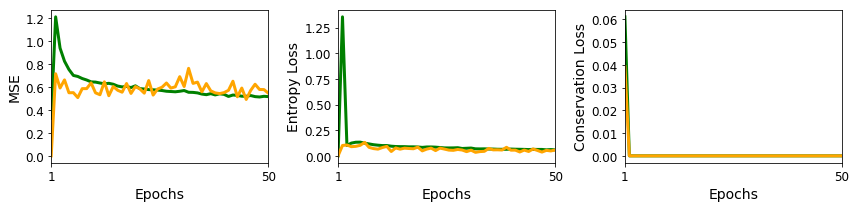

In [20]:

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3 * 4, 3))

n_epochs_actual = len(train_history.history['mse_loss'])

ax1.plot(np.arange(1, n_epochs_actual + 1), train_history.history['mse_loss'], linewidth=3, color='green')
ax1.plot(np.arange(1, n_epochs_actual + 1), train_history.history['val_mse_loss'], linewidth=3, color='orange')

plt.sca(ax1)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("MSE", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

ax2.plot(np.arange(1, n_epochs_actual + 1), train_history.history['entropy_loss'], linewidth=3, color='green')
ax2.plot(np.arange(1, n_epochs_actual + 1), train_history.history['val_entropy_loss'], linewidth=3, color='orange')

plt.sca(ax2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Entropy Loss", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

ax3.plot(np.arange(1, n_epochs_actual + 1), train_history.history['conservation_loss'], linewidth=3, color='green')
ax3.plot(np.arange(1, n_epochs_actual + 1), train_history.history['val_conservation_loss'], linewidth=3, color='orange')

plt.sca(ax3)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Conservation Loss", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()


In [21]:
# Save model and weights
save_dir = 'saved_models'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name + '.h5')

scrambler_model.save(model_path)
print('Saved scrambler model at %s ' % (model_path))


Saved scrambler model at saved_models/autoscrambler_dataset_egfp_unmod_1_sample_mode_gumbel_n_samples_32_resnet_5_4_32_3_00_00_to_015_n_epochs_50_target_bits_0125_example_if_uorf_seqs_drop_multi_scale_weight_10.h5 


In [19]:
#Load models
save_dir = 'saved_models'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name + '.h5')
scrambler_model.load_weights(model_path)

print('Loaded scrambler model %s ' % (model_path))


Loaded scrambler model saved_models/autoscrambler_dataset_egfp_unmod_1_sample_mode_gumbel_n_samples_32_resnet_5_4_32_3_00_00_to_015_n_epochs_50_target_bits_0125_example_if_uorf_seqs_drop_multi_scale_weight_10.h5 


In [20]:

def _drop_seq_to_mask(s) :
    return np.reshape(
        np.array([0. if s[i] == 'X' else 1. for i in range(len(s))]),
        (1, 1, len(s), 1)
    )

e_extra = pd.DataFrame({
    'utr' : [
        "CTGGAATGCATCCAAGAGAATCCCTCAACATGCTGGTGGCTTTCTAGAAG", #ENSG00000115295,ENST00000404424
        "GGTCTCATCTCTGCTTCACAATGCCGATGATTTAGCTGGGAGGACCCAAA", #ENSG00000182346,ENST00000473269
        "GAATGGGTTATATCCTGTGTTGTGACCTCATGGTTTAAGTGGGAATAAAG", #ENSG00000177565,ENST00000431674
        "CAAGAGAAAGTAAAGAATTTAAGATTTTATTCATGTGCATGGCATAGAAG", #ENSG00000104442,ENST00000519352
        "GGGAGCTAGAGATGCTGTTATTCTATTGTATGTGAGAAGTCGGCCCAGAG", #ENSG00000168038,ENST00000420927
    ]
})
seq_e_extra = one_hot_encode(e_extra, seq_len=50)
x_extra = seq_e_extra
x_extra = np.reshape(x_extra, (x_extra.shape[0], 1, x_extra.shape[1], x_extra.shape[2]))

y_extra = np.zeros((x_extra.shape[0],1))

drop_test = [
   #_drop_seq_to_mask("CTGGAATGCATCCAAGAGAATCCCTCAACATGCTGGTGGCTTTCTAGAAG"),
    _drop_seq_to_mask("NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN"),
    _drop_seq_to_mask("NNNNNXXXNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN"),
    _drop_seq_to_mask("NNNNNNNNNNNNNNNNNNNNNNNNNNNNNXXXNNNNNNNNNNNNNNNNNN"),
   #_drop_seq_to_mask("GGTCTCATCTCTGCTTCACAATGCCGATGATTTAGCTGGGAGGACCCAAA"),
    _drop_seq_to_mask("NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN"),
    _drop_seq_to_mask("NNNNNNNNNNNNNNNNNNNNXXXNNNNNNNNNNNNNNNNNNNNNNNNNNN"),
    _drop_seq_to_mask("NNNNNNNNNNNNNNNNNNNNNNNNNNXXXNNNNNNNNNNNNNNNNNNNNN"),
   #_drop_seq_to_mask("GAATGGGTTATATCCTGTGTTGTGACCTCATGGTTTAAGTGGGAATAAAG"),
    _drop_seq_to_mask("NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN"),
    _drop_seq_to_mask("NNXXXNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN"),
    _drop_seq_to_mask("NNNNNNNNNNNNNNNNNNNNNNNNNNNNNXXXNNNNNNNNNNNNNNNNNN"),
   #_drop_seq_to_mask("CAAGAGAAAGTAAAGAATTTAAGATTTTATTCATGTGCATGGCATAGAAG"),
    _drop_seq_to_mask("NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN"),
    _drop_seq_to_mask("NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNXXXNNNNNNNNNNNNNNN"),
    _drop_seq_to_mask("NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNXXXNNNNNNNNN"),
   #_drop_seq_to_mask("GGGAGCTAGAGATGCTGTTATTCTATTGTATGTGAGAAGTCGGCCCAGAG"),
    _drop_seq_to_mask("NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN"),
    _drop_seq_to_mask("NNNNNNNNNNNXXXNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN"),
    _drop_seq_to_mask("NNNNNNNNNNNNNNNNNNNNNNNNNNNNNXXXNNNNNNNNNNNNNNNNNN"),
]

new_x_test = [
    x_extra[0:1, ...],
    x_extra[0:1, ...],
    x_extra[0:1, ...],
    x_extra[1:2, ...],
    x_extra[1:2, ...],
    x_extra[1:2, ...],
    x_extra[2:3, ...],
    x_extra[2:3, ...],
    x_extra[2:3, ...],
    x_extra[3:4, ...],
    x_extra[3:4, ...],
    x_extra[3:4, ...],
    x_extra[4:5, ...],
    x_extra[4:5, ...],
    x_extra[4:5, ...],
]

drop_test = np.concatenate(drop_test, axis=0)
new_x_test = np.concatenate(new_x_test, axis=0)


In [21]:
#Execute training procedure

s_test = np.zeros((batch_size, 1))

pwm_test = []
sample_test = []
importance_scores_test = []

for data_ix in range(new_x_test.shape[0]) :
    
    print("Predicting example " + str(data_ix) + "...")
    
    _, temp_pwm, temp_sample, temp_importance_scores = scrambler_model.predict_on_batch(x=[
        np.tile(new_x_test[data_ix:data_ix+1], (batch_size, 1, 1, 1)),
        np.tile(drop_test[data_ix:data_ix+1], (batch_size, 1, 1, 1)),
        s_test
    ])
    
    pwm_test.append(temp_pwm[:1, :])
    sample_test.append(temp_sample[:1, :])
    importance_scores_test.append(temp_importance_scores[:1, :])

pwm_test = np.concatenate(pwm_test, axis=0)
sample_test = np.concatenate(sample_test, axis=0)
importance_scores_test = np.concatenate(importance_scores_test, axis=0)


Predicting example 0...
Predicting example 1...
Predicting example 2...
Predicting example 3...
Predicting example 4...
Predicting example 5...
Predicting example 6...
Predicting example 7...
Predicting example 8...
Predicting example 9...
Predicting example 10...
Predicting example 11...
Predicting example 12...
Predicting example 13...
Predicting example 14...


Test sequence 0:
 - Prediction (original) = -1.7
 - Predictions (scrambled) = [-0.7, -1.0, -1.4, -1.0, -1.1, -1.2, -1.0, -1.1, -1.0, -0.7]


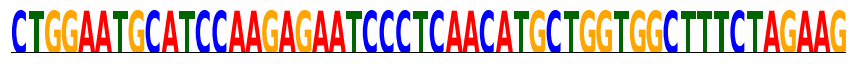

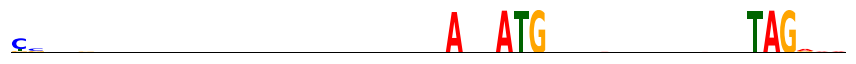

Test sequence 1:
 - Prediction (original) = -1.7
 - Predictions (scrambled) = [-0.8, -0.9, -0.6, -1.1, -0.9, -0.9, -0.9, -0.9, -1.1, -1.0]


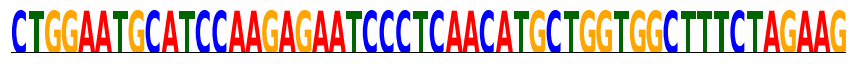

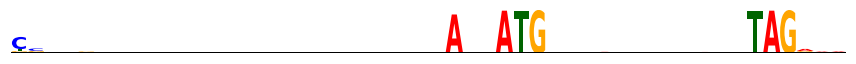

Test sequence 2:
 - Prediction (original) = -1.7
 - Predictions (scrambled) = [-1.3, -1.1, -0.6, -1.3, -1.1, -1.0, -1.0, -0.8, -1.0, -1.0]


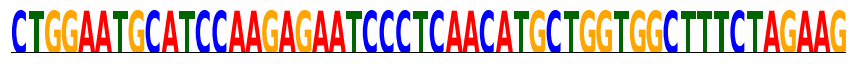

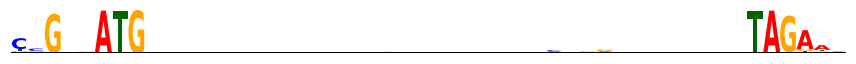

Test sequence 3:
 - Prediction (original) = -1.0
 - Predictions (scrambled) = [-0.5, -0.3, -0.6, -0.7, -0.9, -0.8, -0.9, -0.9, -0.7, -0.2]


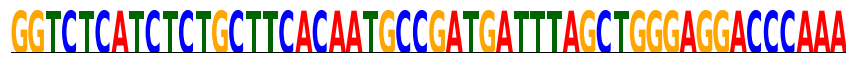

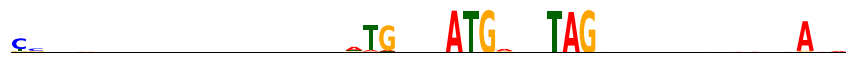

Test sequence 4:
 - Prediction (original) = -1.0
 - Predictions (scrambled) = [-0.9, -0.5, -0.4, -0.6, -0.8, -0.4, -0.7, -0.8, -0.8, -0.7]


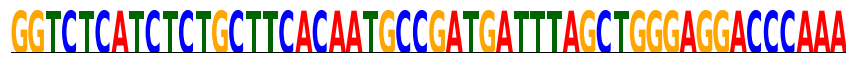

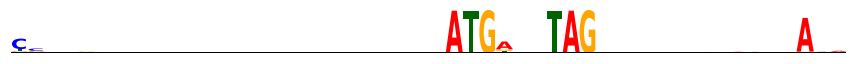

Test sequence 5:
 - Prediction (original) = -1.0
 - Predictions (scrambled) = [-0.9, -1.3, -0.9, -0.7, -0.7, -0.8, -0.7, -0.6, -0.8, -0.7]


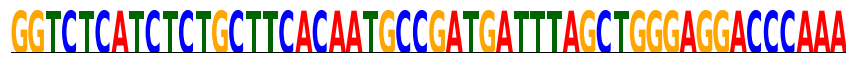

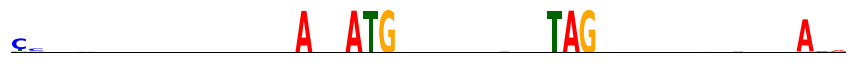

Test sequence 6:
 - Prediction (original) = -1.2
 - Predictions (scrambled) = [-0.7, -0.5, -0.2, -0.5, -0.6, -0.8, -0.7, -0.9, -0.3, -0.4]


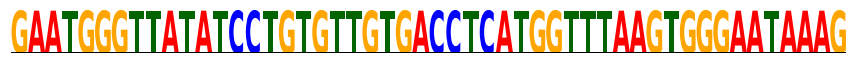

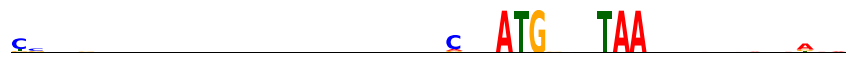

Test sequence 7:
 - Prediction (original) = -1.2
 - Predictions (scrambled) = [-0.4, -0.6, -0.0, -0.1, -0.3, -0.6, -0.9, -0.4, -0.1, -1.0]


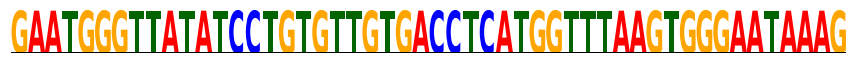

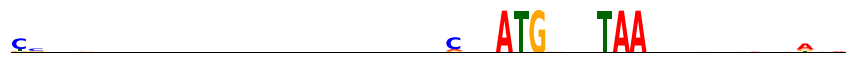

Test sequence 8:
 - Prediction (original) = -1.2
 - Predictions (scrambled) = [-1.1, -1.0, -1.1, 0.4, -0.9, -0.4, -0.0, -0.4, -0.8, -1.2]


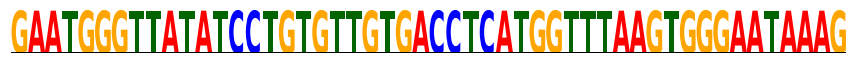

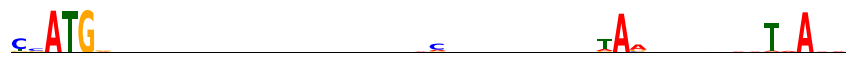

Test sequence 9:
 - Prediction (original) = -0.3
 - Predictions (scrambled) = [-0.6, -0.4, -1.1, 0.01, -0.7, -1.0, -0.9, -0.7, -0.7, -0.6]


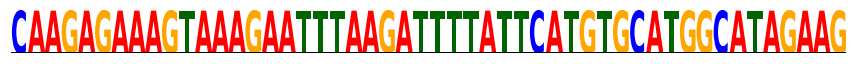

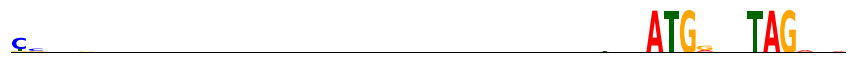

Test sequence 10:
 - Prediction (original) = -0.3
 - Predictions (scrambled) = [-1.2, -0.5, -1.0, -0.7, -0.7, -0.6, -0.9, -1.0, -0.9, -1.0]


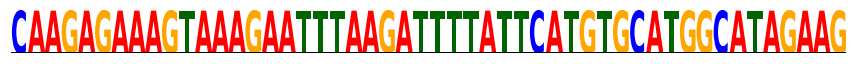

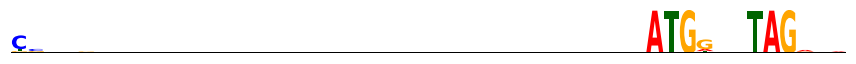

Test sequence 11:
 - Prediction (original) = -0.3
 - Predictions (scrambled) = [-0.9, -2.2, -0.6, -0.8, -0.9, -0.8, -1.0, -0.7, -0.5, -0.4]


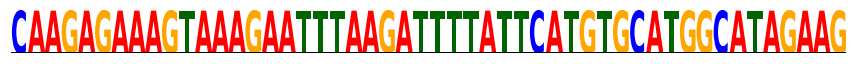

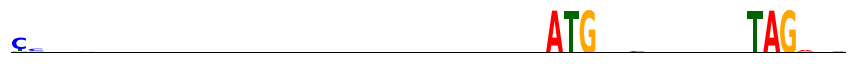

Test sequence 12:
 - Prediction (original) = -0.6
 - Predictions (scrambled) = [-1.2, -0.7, -0.9, -0.6, -0.5, -0.5, -1.4, -1.1, -0.7, -0.4]


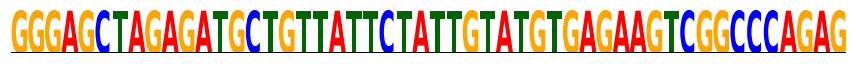

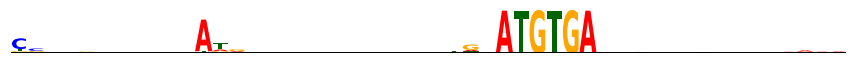

Test sequence 13:
 - Prediction (original) = -0.6
 - Predictions (scrambled) = [-0.1, -1.1, -0.4, -0.7, -0.6, -1.3, -0.9, -0.9, -0.6, -1.3]


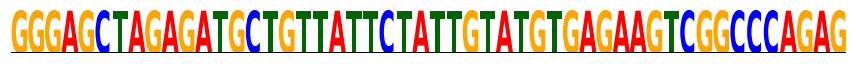

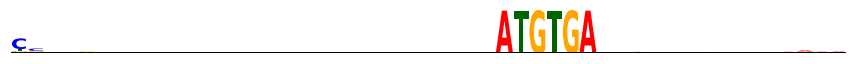

Test sequence 14:
 - Prediction (original) = -0.6
 - Predictions (scrambled) = [-1.5, -0.2, -0.7, -0.9, -0.0, -0.5, -0.2, 0.24, -1.6, -0.8]


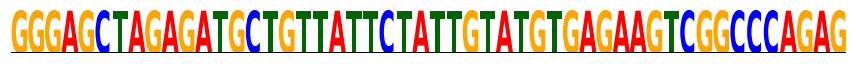

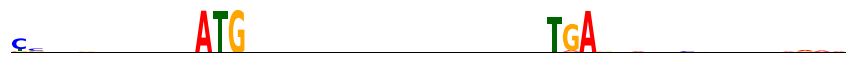

In [22]:
#Visualize a few reconstructed sequence patterns
from sequence_logo_helper import plot_dna_logo

save_figs = True
fig_name = model_name[model_name.index("target_bits"):] + "_human_examples"

for plot_i in range(0, new_x_test.shape[0]) :
    
    print("Test sequence " + str(plot_i) + ":")
    
    justPred = np.expand_dims(np.expand_dims(new_x_test[plot_i, 0, :, :], axis=0), axis=-1)
    justPredReshape = np.reshape(justPred, (1,50,4))
    
    expanded = np.expand_dims(sample_test[plot_i, :, 0, :, :], axis=-1)
    expandedReshape = np.reshape(expanded, (n_samples, 50,4))
    
    y_test_hat_ref = predictor.predict(x=justPredReshape, batch_size=1)[0][0]
    y_test_hat = predictor.predict(x=[expandedReshape], batch_size=32)[:10, 0]
    
    print(" - Prediction (original) = " + str(round(y_test_hat_ref, 2))[:4])
    print(" - Predictions (scrambled) = " + str([float(str(round(y_test_hat[i], 2))[:4]) for i in range(len(y_test_hat))]))
    
    plot_dna_logo(new_x_test[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(12, 1), plot_start=0, plot_end=50, save_figs=save_figs, fig_name=fig_name + "_" + str(plot_i) + "_orig_sequence")
    plot_dna_logo(pwm_test[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(12, 1), plot_start=0, plot_end=50, save_figs=save_figs, fig_name=fig_name + "_" + str(plot_i) + "_scrambled_pwm")
